# Synthetic dataset

In this file we are going to generate synthetic noisy data. The result of this section will be used for training a TD3 model to eliminate noise and reconstruct phylogenetic tree.

It is mentiond that the generated data contains both SNV matrix and CNV profile per sample beside ground-truth tree.

____

## Setup Docker

In [1]:
# !git config --global user.email "afshinbigboy@gmail.com"
# !git config --global user.name "Afshin"

In [2]:
!apt update
!apt --assume-yes install python-pydot python-pydot-ng graphviz

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease         
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease       
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Reading package lists... Done             
Building dependency tree       
Reading state information... Done
118 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
python-pydot is already the newest version (1.2.3-1).
python-pydot-ng is already the newest version (1.0.0-3).
0 upgraded, 0 newly installed, 0 to remove and 118 not upgraded.


In [3]:
!pip install --upgrade pip

In [4]:
!pip install -r ../requirements.txt

## Import required packages

In [5]:
import scipy as sp
import numpy as np
from scipy import stats
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib as mpl
import random
import matplotlib.image as mpimg
import graphviz
import imageio, json
from IPython.display import Image
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.patches as mpatches

## Configuration

In [6]:
font = {
    'weight' : 'normal',
    'size'   : 16,
}
mpl.rc('font', **font)

## Define functions

In [7]:
def plot_mat(M, row='', col='', title='', save_name=None):
    rows, cols = M.shape[:2]
    plt.imshow(M, cmap='GnBu', interpolation="nearest")
    plt.yticks(range(E.shape[0]), ['%s %d'%(row,i) for i in range(rows)])
    plt.xticks(range(E.shape[1]), ['%s %d'%(col,i) for i in range(cols)])
    plt.xticks(rotation=60)
    plt.xlabel('{}-{} Matrix'.format(row.capitalize(), col.capitalize()))
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.imshow()
    plt.close()
    
    
def plot_tree(tree, save_name=None):
    pass

## Define classes

### Define the Tree class

In [8]:
class Tree(object):
    def __init__(self, T, E, CP, **params):
        self.__T = T
        self.__E = E
        self.__CP = CP
        self.__N = E.shape[0]
        self.__M = E.shape[1]
        params['N'] = self.__N
        params['M'] = self.__M
        
        self.__plot_scale = 30./max(self.__M, self.__N)
        
        self.__set_params(params)
        self.generate_data(**params)

        
    def generate_data(self, **params):
        self.__new_param = self.__params
        for k,v in params.items():
            self.__new_param[k]=v
        
        if not json.dumps(self.__params) == json.dumps(self.__new_param):
            print('Prev params:')
            print('\t'.join(json.dumps(self.__params, indent=True).splitlines()))
            self.__set_params(self.__new_param)
            print('New params:')
            print('\t'.join(json.dumps(params, indent=True).splitlines()))

        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~~~~~~~~ E to D ~~~~~~~~~~~~~~~~~~~~~~~~
        ## ========================================================
        D = self.__E.copy()
        nz_idxs = np.nonzero(self.__E)
        z_idxs  = np.nonzero(self.__E-1)
        z_rnds  = np.random.rand(len( z_idxs[0]))
        nz_rnds = np.random.rand(len(nz_idxs[0]))
        z_rnds  = [1 if i < self.__alpha  else 0 for i in  z_rnds]
        nz_rnds = [0 if i < self.__beta   else 1 for i in nz_rnds]
        D[nz_idxs] = nz_rnds
        D[ z_idxs] =  z_rnds
        self.__D = D
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~~ add missing data ~~~~~~~~~~~~~~~~~~~~
        ## ========================================================
        Dm = self.__D.copy()
        idxs = np.nonzero(self.__D+1)
        rnds = np.random.rand(self.__N, self.__M)
        for n in range(self.__N):
            for m in range(self.__M):
                if rnds[n, m] < self.__MR:
                    Dm[n, m] = 3
        self.__Dm = Dm
        
        
    def __set_params(self, params):
        self.__alpha = params['alpha']
        self.__beta  = params['beta']
        self.__MR    = params['MR'] # missing rate
        
        self.__params = params
        self.__str_params  ='_'.join(['{}={}'.format(k,v) for k,v in params.items()])
        self.__latex_params='\ '.join(['{}={}'.format(k if len(k)<3 else '\%s'%k,v) for k,v in params.items()])
        
        
    def save_data(save_dir):
        if not save_dir[-1]=='/':
            save_dir += '/'
        p = 'Parameters: {}\n'.format(self.__str_params)
        np.savetxt('{}E.csv'.format(save_dir), E, fmt='%.0f', delimiter=',', header=p)
        np.savetxt('{}D.csv'.format(save_dir), D, fmt='%.0f', delimiter=',', header=p)
        np.savetxt('{}DmE.csv'.format(save_dir), D-E, fmt='%.0f', delimiter=',', header=p)
        np.savetxt('{}Dm.csv'.format(save_dir), Dm, fmt='%.0f', delimiter=',', header=p)
    
                       
    def get_E(self,):
        return self.__E
    
    def get_D(self,):
        return self.__D
                       
    def get_Dm(self,):
        return self.__Dm
    
    def get_T(self,):
        return self.__T
                       
    def get_params(self,):
        return self.__params
                       
    def get_alpha(self,):
        return self.__alpha
    
    def get_beta(self,):
        return self.__beta
    
    
    def save_tree(self, save_path):
        file_path = '{}Tree_{}.gpickle'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
        nx.write_gpickle(self.__T, file_path)
    
    
    def plot_tree_mut(self, save_path):
        mut_T = self.__T.copy()
#         mut_T.remove_nodes_from([i for i,n in enumerate(self.__T.nodes()) if 'cell' in str(n)])
        pdot = nx.drawing.nx_pydot.to_pydot(mut_T)
        file_path = '{}treeM_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
        pdot.write_png(file_path)
        display(Image(filename=file_path))
        
        
    def plot_tree_full(self, save_path, title=None):
        pdot = nx.drawing.nx_pydot.to_pydot(self.__T)
        for i, node in enumerate(pdot.get_nodes()):
            node_name = str(node)[:-1]
            if 'cell' in node_name:
                node.set_label('s%s'%node_name.split()[-1][:-1])
                node.set_shape('egg')
                node.set_fillcolor('#db8625')
                node.set_color('red')
        file_path = '{}treeF_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
        pdot.write_png(file_path)
        if title: print(title)
        display(Image(filename=file_path))
    
    
    def plot_E(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        plt.imshow(self.__E, cmap='GnBu', interpolation="nearest")
        plt.yticks(range(self.__E.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__E.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Genes-Cells Matrix E (Error-less)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}E_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
    
    
    def plot_D(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        plt.imshow(self.__D, cmap='GnBu', interpolation="nearest")
        plt.yticks(range(self.__D.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__D.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Noisy Genes-Cells Matrix D (input Data)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}D_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()

        
    def plot_DmE(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.5,0.5,0.8,t], -1:[0.8,0.5,0.5,t]}
        labels = {0:'true', 1:'false positive', -1:'false negetive'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__D-self.__E])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__E.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__E.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('D-E')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}DmE_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
    
    
    def plot_Dm(self, save_path=None, nofig=False, figsize=None):
        if not nofig:
            plt.figure(figsize=figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale))
        ## first you need to define your color map and value name as a dict
        t = 1 ## alpha value
        cmap = {0:[1,1,0.95,t], 1:[0.2,0.2,0.4,t], 3:[0.8,0.5,0.5,t]}
        labels = {0:'0', 1:'1', 3:'missed'}
        arrayShow = np.array([[cmap[i] for i in j] for j in self.__Dm])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)
        plt.yticks(range(self.__D.shape[0]), ['cell %d'%i for i in range(self.__N)])
        plt.xticks(range(self.__D.shape[1]), [ 'mut %d'%i for i in range(self.__M)])
        plt.xticks(rotation=60)
        plt.xlabel('Noisy Genes-Cells Matrix with Missed Data ($D_m$)')
        plt.title(r'Parameters: ${}$'.format(self.__latex_params))
        if save_path is not None:
            file_path = '{}Dm_{}.png'.format(save_path, self.__str_params) if save_path[-1] == '/' else save_path
            plt.savefig(file_path)
            plt.close()
            return imageio.imread(file_path)
        if not nofig:
            plt.show()
            plt.close()
    
    def plot_all_mat(self, figsize=None):
        figsize = figsize if figsize else (self.__M*self.__plot_scale,self.__N*self.__plot_scale)
        plt.figure(figsize=figsize)
        plt.subplot(2, 2, 1)
        plt.title('E')
        self.plot_E(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 2)
        plt.title('D')
        self.plot_D(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 3)
        plt.title('D-E')
        self.plot_DmE(figsize=np.asarray(figsize)/2, nofig=True)
        plt.subplot(2, 2, 4)
        plt.title('D with missed data')
        self.plot_Dm(figsize=np.asarray(figsize)/2, nofig=True)
        plt.show()

In [9]:
class TreeGenerator():
    '''
    Inputs: (M, N, ZETA, Gamma, alpha, beta, MR, save_images, save_trees, save_mats)
        --------------------------------------
        M       :   num of genes (mutations)
        --------------------------------------
        N       :   num of samples (cells)
        --------------------------------------
        ZETA    :   homogeness of tree
        --------------------------------------
        Gamma   :   merge genes
        --------------------------------------
        alpha   :   ~ P(D=1|E=0)
        --------------------------------------
        beta    :   ~ P(D=0|E=1)
        --------------------------------------
        MR      :   missing ratio
        --------------------------------------

    Outputs: (E, D, Dm, T)
        ------------------------------------------------
        E       :   Mutation-cell matrix without errors
        ------------------------------------------------
        D       :   Mutation-cell matrix with errors
        ------------------------------------------------
        Dm      :   <D> with missed data
        ------------------------------------------------
        T       :   The generated tree
        ------------------------------------------------
    '''

    def __init__(self,
        M, N, 
        ZETA=1, Gamma=0.15, alpha=0.1,beta=0.08, MR=0.05,
        save_dir=None):
        
        M += 1 # add one more for healthy state as the root

        self.M=M
        self.N=max(M, N)
        self.ZETA=ZETA
        self.Gamma=Gamma
        self.alpha=alpha
        self.beta=beta
        self.MR=MR
        self.save_dir=save_dir


    def generate(self,):
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~ generate a random tree ~~~~~~~~~~~~~~~~
        ## ========================================================
        self.Tree = dict()
        self.cnt = 2
        xk = np.arange(self.M+1)
        name_k = [str(i) for i in xk]
        wk = np.ones(self.M+1, dtype=np.float128)
        while True:
            xk, wk, name_k, u, v = self.__do_next(xk, wk, name_k)
            self.cnt+=1
            if len(xk) < 2:
                break
        T = nx.DiGraph(self.Tree)
        T_leaves = [x for x in T.nodes() if T.out_degree(x)==0 and T.in_degree(x)==1]
        T.remove_nodes_from(T_leaves)
        t = np.arange(self.M)
        np.random.shuffle(t)
        t = dict((i, j) for i,j in zip(T.nodes(), t))
        T = nx.relabel_nodes(T, t)
        raw_T = T.copy()
        root = [n for n,d in raw_T.in_degree() if d==0][0]
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~ merge some of mutations ~~~~~~~~~~~~~~~~
        ## ========================================================
        A = int(np.floor(self.Gamma*self.M))
        if A:
            for i in range(A):
                while True:
                    p, c = random.sample(T.edges(),1)[0]
                    if p != root: break
                for child in T.successors(c):
                    T.add_edge(p,child)        
                T.remove_node(c)
                T = nx.relabel_nodes(T, {p: '{} . {}'.format(p,c)})

        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~ add cells to the tree ~~~~~~~~~~~~~~~~
        ## ========================================================
        Mutaions_T = T.copy()
        mutaion_nodes = Mutaions_T.nodes()
        cells = np.array(['cell %d'%i for i in range(self.N)])
        np.random.shuffle(cells)
        for n in mutaion_nodes:
            T.add_edge(n, cells[0])
            cells = cells[1:]
        for cell in cells:
            node = random.sample(mutaion_nodes, 1)[0]
            T.add_edge(node, cell)
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~~~~~~~ Tree to E ~~~~~~~~~~~~~~~~~~~~~~~
        ## ========================================================
        E = np.zeros([self.N, self.M])        
        for n in range(self.N):
            try:
                path = list(nx.all_simple_paths(T, root, 'cell %d'%n))[0]
            except:
                print('root:', root)
                pdot = nx.drawing.nx_pydot.to_pydot(T)
                pdot.write_png('problem_tree.png')
                exit()
            for g in path[:-1]:
                try:
                    E[n, int(g)] = 1
                except:
                    gs = g.split(' . ')
                    for g in gs:
                        E[n, int(g)] = 1
                        
#         np.delete(E, int(root), axis=1)
        E[: ,int(root)] = 0        
        ## ========================================================
        ## ~~~~~~~~~~~~ perform acceptable losses (CP) ~~~~~~~~~~~~
        ## ========================================================
        '''
        0. Prpare list of links named `all_L`
        1. Choose a random link L_i:(M_u->M_v) from `all_L` if their contain at least one sample individualy.
            In fact we choose two samples (S_u, S_v).
        2. Choose a set of mutations in ancestors of `M_v` named M_xs.
        3.  [a] Add an attribute to selected link L_i:(loss M_x).
            [b] For each cell_i that contains M_v, triger M_x to 0.
            [c] Write "L(S_u,_Sv): M_xs" in the CP_gt.txt file.
            [d] Write "L(S_u,_Sv): M_xs,<some random Ms in [M in path (v->root)]-[M_xs]>" in the CP.txt file.
        4. Remove L_i from `all_L`
        5. If it is not enough go to step 1.
        6. Repeat Y times above loop to achieve additional L(i,j). 
            But in this case append them just to the CP.txt file.
        '''
        
#         # step 0.
#         links = self.__T.edges(data=True)
#         # step 1.
#         while True:
#             l_i = random.choice(links)
#             if 
        
#         E_CL = E.copy()
        
#         for n in range(self.N):
#             try:
#                 path = list(nx.all_simple_paths(T, root, 'cell %d'%n))[0]
#             except:
#                 print('root:', root)
#                 pdot = nx.drawing.nx_pydot.to_pydot(T)
#                 pdot.write_png('problem_tree.png')
#                 exit()
#             for g in path[:-1]:
#                 try:
#                     E[n, int(g)] = 1
#                 except:
#                     gs = g.split(' . ')
#                     for g in gs:
#                         E[n, int(g)] = 1
        
        ## ========================================================
        ## ~~~~~~~~~~~~~~~~ return generated data ~~~~~~~~~~~~~~~~~
        ## ========================================================
        tree_obj = Tree(
            T=T.copy(), E=E, CP=None,
            zeta = self.ZETA,
            gamma = self.Gamma,
            alpha = self.alpha,
            beta = self.beta,
            MR = self.MR,
        )
        return tree_obj
        return (E.astype(int), D.astype(int), Dm.astype(int), raw_T)


    def __do_next(self, xk, wk, name_k):
        u, v = self.__weighted_drand(xk, wk, size=2)
        idx_u = np.where(xk==u)[0]
        idx_v = np.where(xk==v)[0]
        w_u = wk[idx_u]
        w_v = wk[idx_v]
        w_uv = (w_u+w_v)/(self.ZETA**0.25)
        nu = name_k[int(idx_u)]
        nv = name_k[int(idx_v)]
        nuv = '{}.{}'.format(nu, nv)
        self.Tree[nuv] = [nu, nv]
        xk = np.delete(xk, [idx_u, idx_v])
        name_k = np.delete(name_k, [idx_u, idx_v])
        wk = np.delete(wk, [idx_u, idx_v])
        xk = np.append(xk, self.M+self.cnt)
        name_k = np.append(name_k, nuv)
        wk = np.append(wk, w_uv)
        return (xk, wk, name_k, u, v)
    
    @staticmethod
    def __rand_pmf(xk, pk, size=1):
        custm = stats.rv_discrete(name='custm', values=(xk, pk))
        cnt = 0
        while True:
            rs = custm.rvs(size = size)
            if len(set(rs)) == len(rs):
                break
            cnt+=1
        return rs

    def __weighted_drand(self, xk, wk, size=1):
        pk = wk/np.sum(wk, dtype=np.float128)
        return self.__rand_pmf(xk, pk, size)

## Test generator

In [17]:
N, M = 13, 10

generator = TreeGenerator(
    M,
    N,
    ZETA=1,
    Gamma=0.15,
    alpha=0.2,
    beta=0.08,
    MR=0.05,
    save_dir=False,
)

In [18]:
tree_obj = generator.generate()

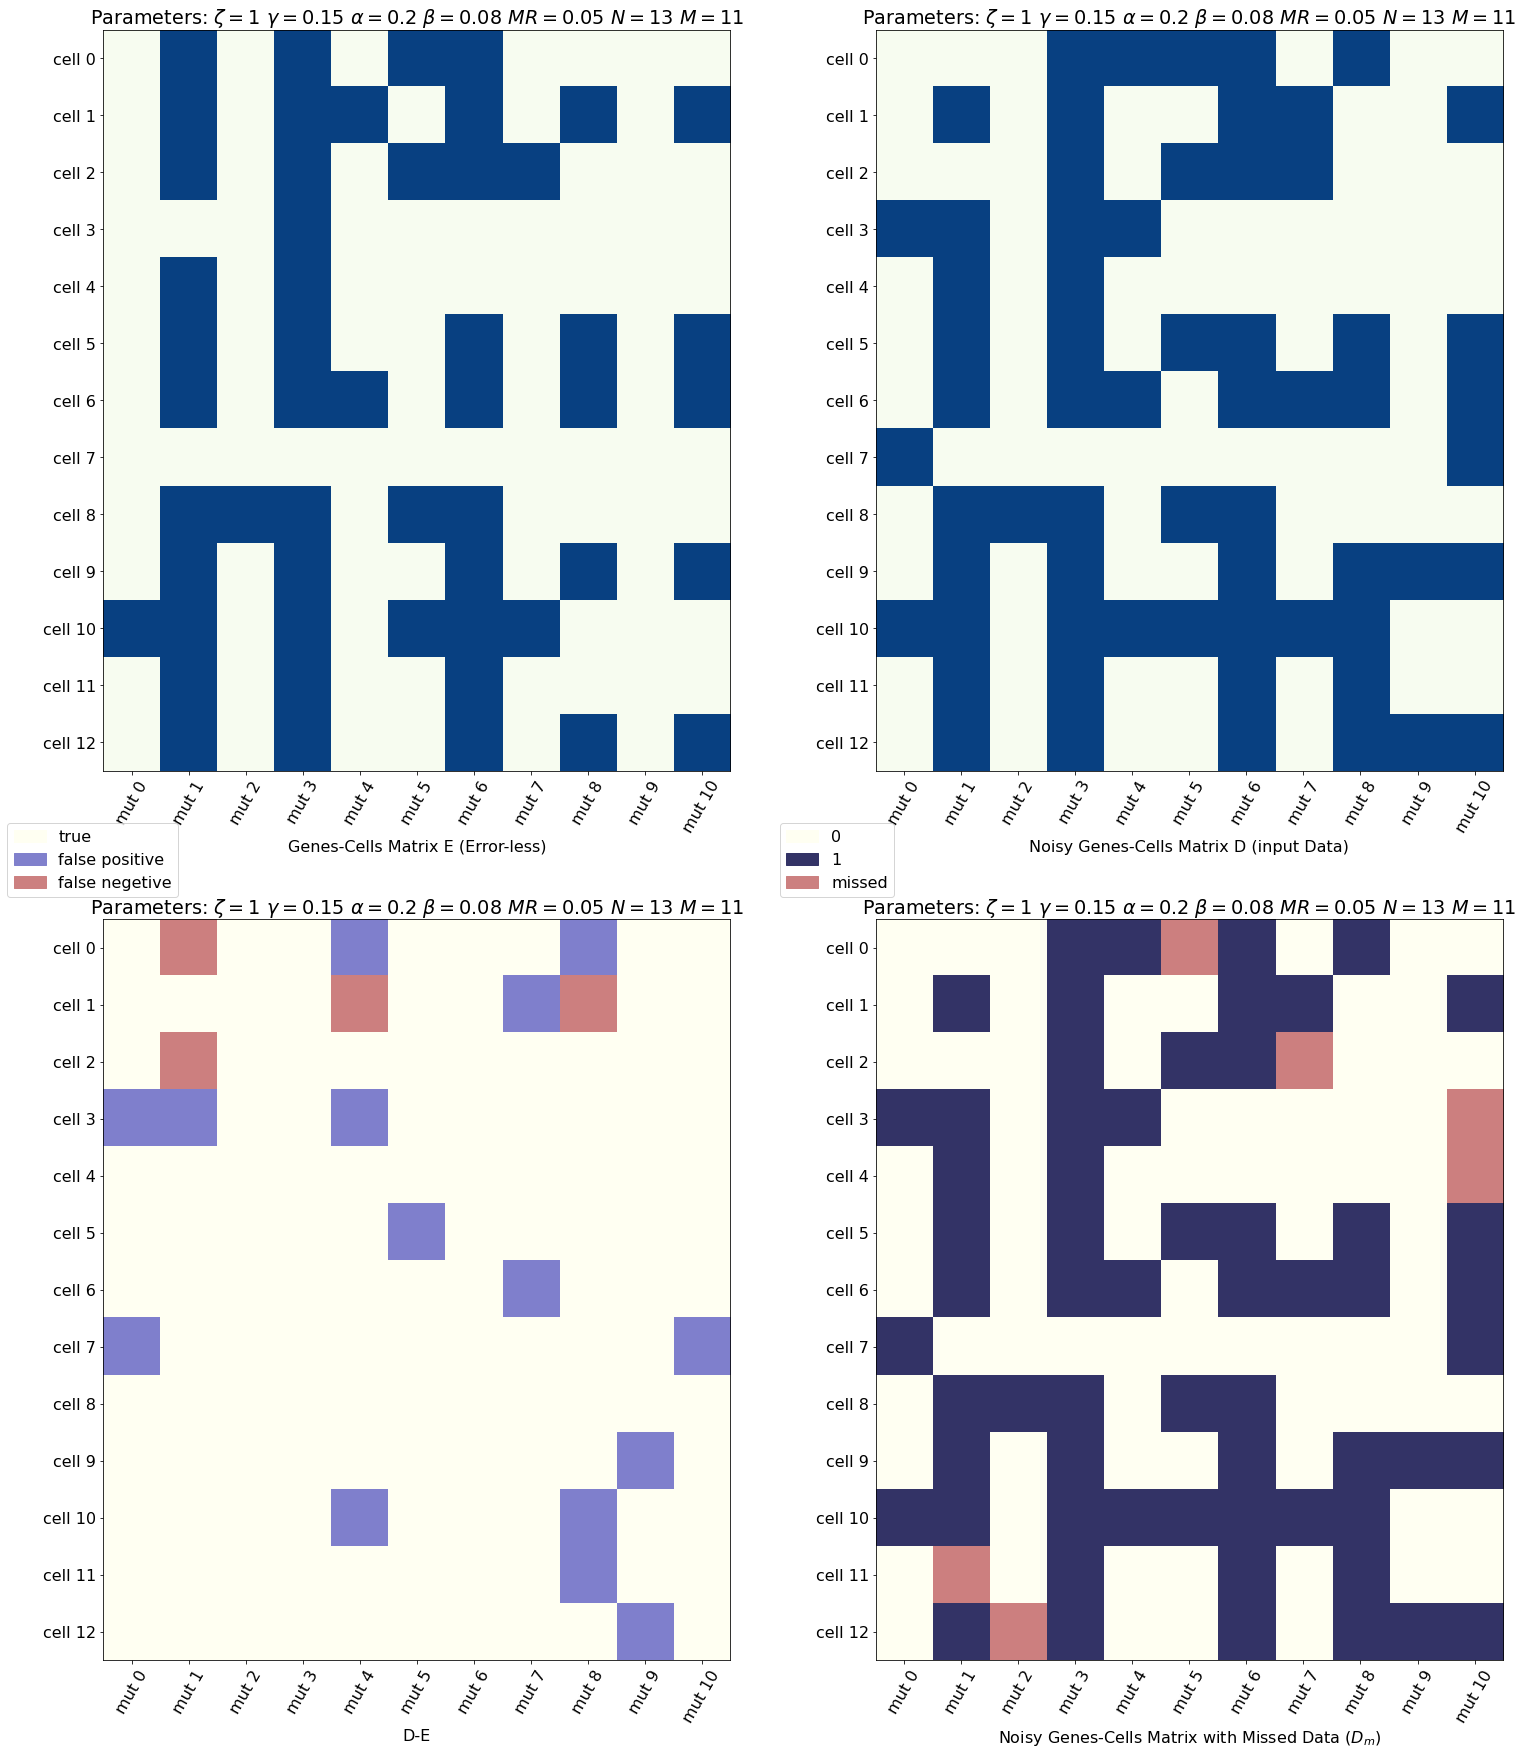

In [19]:
tree_obj.plot_all_mat()

Ground-truth tree with attached samples


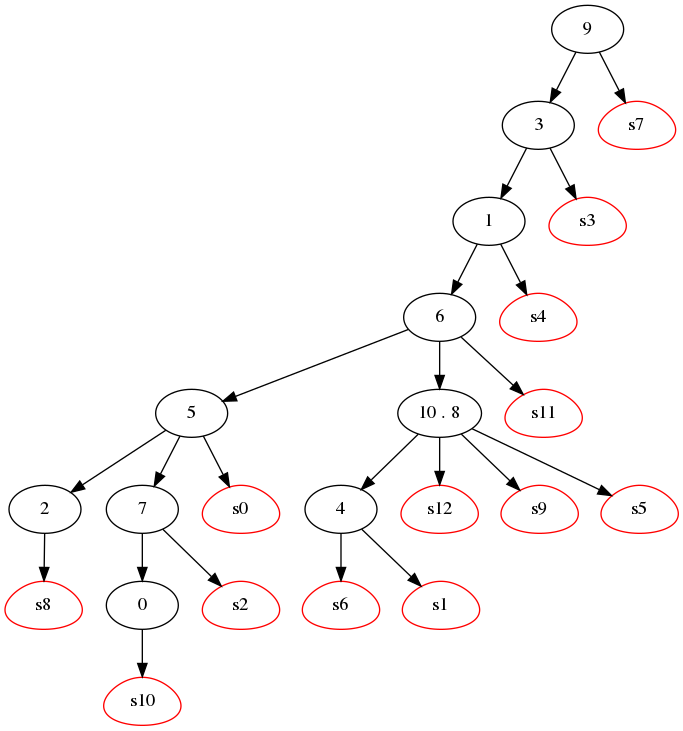

In [20]:
tree_obj.plot_tree_full('../tmp/', title="Ground-truth tree with attached samples")

In [21]:
E = tree_obj.get_E()

In [22]:
E

array([[0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.]])

to generate `CP` (Copy-number Profile)

In [16]:
T = tree_obj.get_T()